<a href="https://colab.research.google.com/github/Taenor/Num_french/blob/main/v4_Transfert_and_KD_from_YAMNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I/ Preparing environment




## 1. Configure Defaults

In [1]:
! pip install tensorflow_io
#! pip install tensorflow-io-nightly

# Define paths to model files
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

pad_z = 15600 #size of audio files used for the model 


     |████████████████████████████████| 22.7MB 1.9MB/s 
     |████████████████████████████████| 2.3MB 31.1MB/s 


## 2. Importing important data

In [2]:
# Import Spoken Digits Dataset
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

# Import personal repo with utilities
_ = tf.keras.utils.get_file('spoken_digits.zip',
                        'https://github.com/Taenor/Spoken_digit_csv/archive/refs/heads/main.zip',
                        cache_dir='./',
                        cache_subdir='csv',
                       extract=True)

# Reorganize the files to simplifie the execution of the program
!git clone https://github.com/tensorflow/models vggish_model 
!cp vggish_model//research/audioset/yamnet/* .
!rm yamnet.py
!cp csv//Spoken_digit_csv-main/yamnet.py .
!cp csv//Spoken_digit_csv-main/yamnet_KD.py .
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

14999552/Unknown - 1s 0us/stepDownloading data from https://github.com/Taenor/Spoken_digit_csv/archive/refs/heads/main.zip
   8192/Unknown - 0s 0us/stepCloning into 'vggish_model'...
remote: Enumerating objects: 58094, done.
remote: Counting objects: 100% (511/511), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 58094 (delta 324), reused 443 (delta 275), pack-reused 57583
Receiving objects: 100% (58094/58094), 573.18 MiB | 25.63 MiB/s, done.
Resolving deltas: 100% (40272/40272), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.5M  100 14.5M    0     0  17.5M      0 --:--:-- --:--:-- --:--:-- 17.5M


In [3]:
# The Yamnet model used here is a personal Yamnet model modified from the original Github distribution
# It doen't use the feature extractor as Input and instead directly accept batched features tensor
# Params and features stay unchanged and will permit to manually extract features from .wav files

import params
import yamnet
import features as features_lib

yamnet_model = yamnet.yamnet_frames_model(params.Params())
yamnet_model.load_weights('yamnet.h5')
yamnet_classes = yamnet.class_names('yamnet_class_map.csv')

# A test file from the used dataset 
testing_wav_file_name = './datasets//free-spoken-digit-dataset-master/recordings/8_yweweler_29.wav'

# A test file from another dataset to test the outside compability
testing_wav_file_name_bis = './csv//Spoken_digit_csv-main/0_Atalina_0.wav'

print(testing_wav_file_name)


./datasets//free-spoken-digit-dataset-master/recordings/8_yweweler_29.wav


In [4]:
# Util functions for loading audio files and ensure the correct sample rate and size

@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

def padding_vggish(audio, taille):
  #print(testing_wav_data.numpy().size)

  if (audio.numpy().size < taille):
    padding = np.zeros(taille-audio.numpy().size)
    audio = tf.concat([audio,padding], axis=0)
  return audio[0:taille]

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
tf.Tensor(15600, shape=(), dtype=int32)


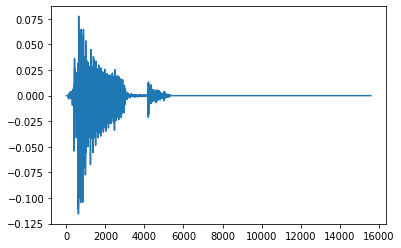

In [5]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)
testing_wav_data_bis = load_wav_16k_mono(testing_wav_file_name_bis)

testing_wav_data = padding_vggish(testing_wav_data,pad_z)
testing_wav_data_bis = padding_vggish(testing_wav_data_bis,pad_z)


_ = plt.plot(testing_wav_data)
print(tf.size(testing_wav_data))

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)


In [6]:
#Original Yamnet classes before transfert
for name in yamnet_classes[:20]:
  print(name)
print('...')


Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [7]:
#Quick test of the Yamnet model
mel,testing_wav_data = features_lib.waveform_to_log_mel_spectrogram_patches( testing_wav_data, params.Params())
testing_wav_data =tf.reshape(testing_wav_data, (1,1,96,64))
mel_bis,testing_wav_data_bis = features_lib.waveform_to_log_mel_spectrogram_patches( testing_wav_data_bis, params.Params())
testing_wav_data_bis =tf.reshape(testing_wav_data_bis, (1,1,96,64))
scores, embeddings = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = yamnet_classes[top_class]

print(f'The main sound is: {infered_class}')
print(f'The embeddings shape: {embeddings.shape}')


The main sound is: Speech
The embeddings shape: (1, 1024)


# II/Dataset

I used a dataset called Spoken Diggits to try to do a transfert learning from the Yamnet model to a Diggit audio recognition model.

Spoken diggits is a data set similar to Mnist but for audio. You have 3000 short audio samples of 6 different speakers, at a 8kHz sample rate (50 per speaker, per diggits).

I created a .csv file with all the metadata needed and 10 equal fold categories to split the data set between train, validation and test.

To realize a good Transfert learning, I normalize all audio .wav to 0.975 sec (1 Yamnet Window), I extract the right tensor from each sound file, I pass it through Yamnet and get the embedding of each sound and I split the data.

A second dataset that as not been through Yamnet is also kept and split. It will be used to train the student model during KD. 

## 1. Formating dataset

In [8]:
esc50_csv = './csv//Spoken_digit_csv-main/free_spoken_digits.csv'
base_data_path = './datasets//free-spoken-digit-dataset-master/recordings/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()


,Filename,target,category,speaker,fold
0,0_george_0.wav,0.0,zero,george,0
1,0_george_10.wav,0.0,zero,george,0
2,0_george_11.wav,0.0,zero,george,1
3,0_george_12.wav,0.0,zero,george,2
4,0_george_13.wav,0.0,zero,george,3


In [9]:
my_classes = ['zero', 'un', 'deux','trois','quatre','cinq','six','sept','huit','neuf']
map_class_to_id = {'zero':0, 'un':1, 'deux':2,'trois':3,'quatre':4,'cinq':5,'six':6,'sept':7,'huit':8,'neuf':9}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['Filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(Filename=full_path)

filtered_pd.head(10)


,Filename,target,category,speaker,fold
0,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,0
1,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,0
2,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,1
3,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,2
4,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,3
5,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,4
6,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,5
7,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,6
8,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,7
9,./datasets//free-spoken-digit-dataset-master/r...,0,zero,george,8


In [10]:
filenames = filtered_pd['Filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [11]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
# for element in main_ds:
#   _ = plt.plot(element[0])
#   #display.Audio(element[0],rate=16000)

main_ds.element_spec


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [12]:
main_ds_norm = [ ]
for element in main_ds:

  #print("avant : "+str(element))
  y = list(element)
  y[0] = padding_vggish(element[0],pad_z)
  element = y
  assert element[0].numpy().size == pad_z, 'erreur de resize :'+ str(element) +str(element[0].numpy().size)
  #print("apres : "+str(element[0].numpy())+str(element[1].numpy()))
  main_ds_norm.append((element[0].numpy(),element[1].numpy(),element[2].numpy()))

print(main_ds.element_spec)
sec_ds = tf.data.Dataset.from_tensors(main_ds_norm[0])
for e in main_ds_norm[1:]:
  next = tf.data.Dataset.from_tensors(e)
  sec_ds = sec_ds.concatenate(next)
  
print(sec_ds.element_spec)
main_ds = sec_ds


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))
(TensorSpec(shape=(15600,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [13]:
def extract_features(wav_data, label, fold):
  mel,features = features_lib.waveform_to_log_mel_spectrogram_patches( wav_data, params.Params())
  return (features, label, fold)
main_ds = main_ds.map(extract_features)
print(main_ds.element_spec)
sec_ds = main_ds #We keep a copy of the dataset before passing it through Yamnet

(TensorSpec(shape=(1, 96, 64), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [14]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  num_embeddings = tf.shape(wav_data)[0]
  wav_data = tf.reshape(wav_data, (1,num_embeddings,96,64))
  scores, embeddings = yamnet_model(wav_data)
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings)
          )
# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

## 2. Split the Data

In [15]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: int(fold) < 8)
val_ds = cached_ds.filter(lambda embedding, label, fold: int(fold) == 8)
test_ds = cached_ds.filter(lambda embedding, label, fold: int(fold) == 9)

#remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)
r_ds= cached_ds.map(remove_fold_column).batch(32)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)


In [16]:
cached_ds = sec_ds.cache()
sec_train_ds = cached_ds.filter(lambda embedding, label, fold: int(fold) < 8)
sec_val_ds = cached_ds.filter(lambda embedding, label, fold: int(fold) == 8)
sec_test_ds = cached_ds.filter(lambda embedding, label, fold: int(fold) == 9)

#remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

sec_train_ds = sec_train_ds.map(remove_fold_column)
sec_val_ds = sec_val_ds.map(remove_fold_column)
sec_test_ds = sec_test_ds.map(remove_fold_column)

sec_train_ds = sec_train_ds.cache().shuffle(900).prefetch(tf.data.AUTOTUNE)
sec_val_ds = sec_val_ds.cache().prefetch(tf.data.AUTOTUNE)
sec_test_ds = sec_test_ds.cache().prefetch(tf.data.AUTOTUNE)


# III/ Tranfert learning from Yamnet with a Classifier

### 1. Design the Classifier Model


In [17]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()


Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 132,490
Trainable params: 132,490
Non-trainable params: 0
_________________________________________________________________


In [18]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)


### 2. Train the Classifier Model


In [19]:
history = my_model.fit(train_ds,
                       epochs=50,
                       validation_data=val_ds,
                       callbacks=callback)


Epoch 1/50
75/75 [==============================] - 48s 392ms/step - loss: 2.1710 - accuracy: 0.2717 - val_loss: 2.0800 - val_accuracy: 0.2700
Epoch 2/50
75/75 [==============================] - 8s 108ms/step - loss: 1.8809 - accuracy: 0.3800 - val_loss: 1.7843 - val_accuracy: 0.3300
Epoch 3/50
75/75 [==============================] - 8s 106ms/step - loss: 1.6281 - accuracy: 0.4550 - val_loss: 1.5385 - val_accuracy: 0.4700
Epoch 4/50
75/75 [==============================] - 7s 89ms/step - loss: 1.4084 - accuracy: 0.5408 - val_loss: 1.4080 - val_accuracy: 0.4900
Epoch 5/50
75/75 [==============================] - 7s 89ms/step - loss: 1.2565 - accuracy: 0.5833 - val_loss: 1.2620 - val_accuracy: 0.5900
Epoch 6/50
75/75 [==============================] - 8s 106ms/step - loss: 1.1428 - accuracy: 0.6204 - val_loss: 1.1935 - val_accuracy: 0.5767
Epoch 7/50
75/75 [==============================] - 7s 90ms/step - loss: 1.0334 - accuracy: 0.6633 - val_loss: 1.1509 - val_accuracy: 0.5767
Epoch 8/

In [20]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


10/10 [==============================] - 7s 18ms/step - loss: 0.4815 - accuracy: 0.8400
Loss:  0.4815121591091156
Accuracy:  0.8399999737739563


### 3. Test the Classifier model

In [21]:
scores, embeddings = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

class_scores = tf.reduce_mean(result, axis=0)
top_class = tf.argmax(class_scores)
infered_class = my_classes[top_class]
#infered_class = my_classes[result.mean(axis=0).argmax()]
#print(result)
print(f'The main sound is: {infered_class}')

scores, embeddings = yamnet_model(testing_wav_data_bis)
result = my_model(embeddings).numpy()

class_scores = tf.reduce_mean(result, axis=0)
top_class = tf.argmax(class_scores)
infered_class = my_classes[top_class]
#infered_class = my_classes[result.mean(axis=0).argmax()]
#print(result)
print(f'The main sound is: {infered_class}')


The main sound is: huit
The main sound is: zero


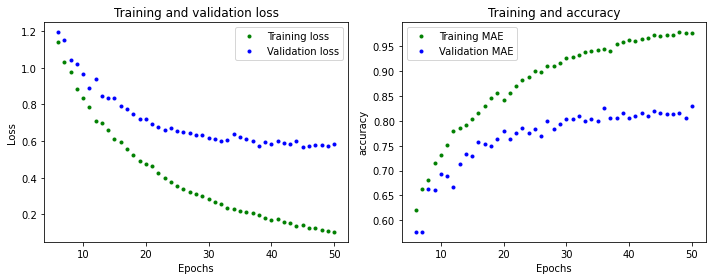

In [22]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['accuracy']
val_mae = history.history['val_accuracy']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()

## 4. Generate a TensorFlow Lite Model

### a) Generate Models with or without Quantization
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of a model is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's weights, and possibly the activations (output of each layer) as well, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

In the following cell, we'll convert the model twice: once with quantization, once without.

In [23]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [24]:
saved_model_path = './digits_yamnet'

input_segment = tf.keras.layers.Input(shape=(None,96,64), dtype=tf.float32, name='audio')
embeddings_output = yamnet_model(input_segment)
serving_outputs = my_model(embeddings_output[1])
#serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./digits_yamnet/assets


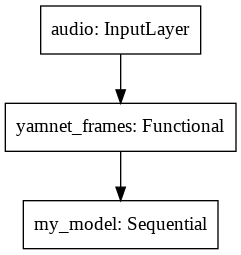

In [25]:
tf.keras.utils.plot_model(serving_model)

In [26]:
#reloaded_model = tf.saved_model.load(saved_model_path)

In [27]:
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
KD_MODEL_TF = MODELS_DIR + 'KD_model'
KD_MODEL_NO_QUANT_TFLITE =  MODELS_DIR + 'KD_model_no_quant.tflite'
KD_MODEL_TFLITE = MODELS_DIR + 'KD_model.tflite'
KD_MODEL_TFLITE_MICRO = MODELS_DIR + 'KD_model.cc'

In [28]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)


13334616

In [29]:

# Convert the model to the TensorFlow Lite format with quantization
print(sec_ds.batch(32).element_spec)
def representative_dataset():
  for data in sec_ds.batch(32):
    yield [tf.dtypes.cast(data[0], tf.float32)]
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset#representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

(TensorSpec(shape=(None, 1, 96, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))


3649104

### b) Generate a TensorFlow Lite for Microcontrollers Model
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [30]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2,188 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2,656 kB]
Ign:13 https://developer.download.nvidia.co

# IV/ Knowledge Distillation and Quantization of Complete Model



## 1. Distillation

We create a new model inspired by the original **Yamnet** model and realize a cross training of this small model to teach him to imitate the bigger model trained above.

I followed a method of training used for embedding **VGGish** (another audio analysis model, develloped by the same team than Yamnet). You can find this method in this article : 

https://arxiv.org/pdf/2001.10876.pdf

### Distiller Class and Student model


In [31]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher, teacher_embed):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
        self.teacher_embed = teacher_embed

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        teacher_embed_predictions = self.teacher_embed(x, training=False)[1]

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions,student_embed_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            embed_loss =  tf.keras.backend.sum(tf.keras.backend.square(teacher_embed_predictions - student_embed_predictions), axis=-1)
            loss = self.alpha * student_loss + (1 - self.alpha)/2 * distillation_loss + (1 - self.alpha)/2 * embed_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"sd_loss": student_loss, "dst_loss": distillation_loss, "embed_loss": embed_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)[0]

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    def call(self, inputs):
      
        student_predictions,student_embed_predictions = self.student(inputs)
        return student_predictions,student_embed_predictions


In [32]:
# Create the teacher
teacher = serving_model

# Create the student
import yamnet_KD as stud
pad = params.Params().conv_padding
student_embed = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(None,1,96,64), dtype=tf.float32, name='audio'),
        tf.keras.layers.Reshape((96,64,1)),
        tf.keras.layers.Conv2D(2, (3,3), strides=2, padding=pad,use_bias=False,activation=None,name='Conv1'),
        tf.keras.layers.BatchNormalization(name='Norm0',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ0'),
     
        tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=1, depth_multiplier=1,padding=pad,use_bias=False,activation=None,data_format='channels_last',name='depthConv1'),
        tf.keras.layers.BatchNormalization(name='Norm1',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ1'),
        tf.keras.layers.Conv2D(4, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv2'),
        tf.keras.layers.BatchNormalization(name='Norm2',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ2'),

        tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=2, depth_multiplier=1, padding=pad, use_bias=False,activation=None,data_format='channels_last',name='depthConv2'),
        tf.keras.layers.BatchNormalization(name='Norm3',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ3'),
        tf.keras.layers.Conv2D(8, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv3'),
        tf.keras.layers.BatchNormalization(name='Norm4',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ4'),
     
        # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=1, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv3'),
        # tf.keras.layers.BatchNormalization(name='Norm5',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ5'),
        # tf.keras.layers.Conv2D(32, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv4'),
        # tf.keras.layers.BatchNormalization(name='Norm6',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ6'),
     
        tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=2, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv4'),
        tf.keras.layers.BatchNormalization(name='Norm7',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ7'),
        tf.keras.layers.Conv2D(16, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv5'),
        tf.keras.layers.BatchNormalization(name='Norm8',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ8'),
     
        # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=1, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv5'),
        # tf.keras.layers.BatchNormalization(name='Norm9',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ9'),
        # tf.keras.layers.Conv2D(32, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv6'),
        # tf.keras.layers.BatchNormalization(name='Norm10',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ10'),
     
        # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=2, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv6'),
        # tf.keras.layers.BatchNormalization(name='Norm11',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ11'),
        # tf.keras.layers.Conv2D(32, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv7'),
        # tf.keras.layers.BatchNormalization(name='Norm12',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ12'),
     
        tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=1, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv7'),
        tf.keras.layers.BatchNormalization(name='Norm13',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ13'),
        tf.keras.layers.Conv2D(32, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv8'),
        tf.keras.layers.BatchNormalization(name='Norm14'),
        tf.keras.layers.ReLU(name='Activ14'),
     
        # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=1, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv8'),
        # tf.keras.layers.BatchNormalization(name='Norm15',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ15'),
        # tf.keras.layers.Conv2D(64, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv9'),
        # tf.keras.layers.BatchNormalization(name='Norm16',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ16'),
     
        # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=1, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv9'),
        # tf.keras.layers.BatchNormalization(name='Norm17',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ17'),
        # tf.keras.layers.Conv2D(64, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv10'),
        # tf.keras.layers.BatchNormalization(name='Norm18',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ18'),
     
        # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=1, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv10'),
        # tf.keras.layers.BatchNormalization(name='Norm19',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ19'),
        # tf.keras.layers.Conv2D(64, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv11'),
        # tf.keras.layers.BatchNormalization(name='Norm20',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ20'),
     
        # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=1, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv11'),
        # tf.keras.layers.BatchNormalization(name='Norm21',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ21'),
        # tf.keras.layers.Conv2D(64, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv12'),
        # tf.keras.layers.BatchNormalization(name='Norm22',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        # tf.keras.layers.ReLU(name='Activ22'),
     
        tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=2, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv12'),
        tf.keras.layers.BatchNormalization(name='Norm23',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ23'),
        tf.keras.layers.Conv2D(64, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv13'),
        tf.keras.layers.BatchNormalization(name='Norm24',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ24'),
     
        tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=1, depth_multiplier=1, padding=pad, use_bias=False,data_format='channels_last',activation=None,name='depthConv13'),
        tf.keras.layers.BatchNormalization(name='Norm25',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ25'),
        tf.keras.layers.Conv2D(1024, kernel_size=(1,1), strides=1, padding=pad,use_bias=False,activation=None,name='Conv14'),
        tf.keras.layers.BatchNormalization(name='Norm26',center=params.Params().batchnorm_center, scale=params.Params().batchnorm_scale, epsilon=params.Params().batchnorm_epsilon),
        tf.keras.layers.ReLU(name='Activ26'),
     
        tf.keras.layers.GlobalAveragePooling2D(name='AveragePool'),

        # tf.keras.layers.Dense(128),
        # tf.keras.layers.Dense(10),
    ],
    name="student_embed",
)

#student_embed.summary()

def student(features):
  embeddings = student_embed(features)
  classifier = tf.keras.layers.Dense(64)(embeddings)
  logits = tf.keras.layers.Dense(10)(embeddings)
  return logits, embeddings


def student_model():
  features = tf.keras.layers.Input(batch_shape=(None,1,96,64), dtype=tf.float32)
  logits, embeddings = student(features)
  student_model = tf.keras.Model(name='student', inputs=features, outputs=[logits,embeddings])
  return student_model


KD_student = student_model()
#student =  stud.yamnet_frames_model(params.Params())       #hub.load(yamnet_model_handle)
# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(KD_student)



In [33]:
teacher.summary()
KD_student.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio (InputLayer)           [(None, None, 96, 64)]    0         
_________________________________________________________________
yamnet_frames (Functional)   [(None, 521), (None, 1024 3751369   
_________________________________________________________________
my_model (Sequential)        (None, 10)                132490    
Total params: 3,883,859
Trainable params: 3,861,971
Non-trainable params: 21,888
_________________________________________________________________
Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 96, 64)]       0         
_________________________________________________________________
student_embed (Sequential)   (None, 1024)              73276     
_____________________________

###KD training

Firslty, we train a copy of the student model from scratch using the same data to compare the result of a normal training to the result of a KD training.

The second step is to use the Distiller class to train our student model.

In [34]:
student_scratch.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

history = student_scratch.fit(sec_train_ds.batch(32),
                       epochs=20,
                       validation_data=sec_val_ds.batch(32),
                       callbacks=callback)

Epoch 1/20
     74/Unknown - 19s 116ms/step - loss: 9.3649 - dense_4_loss: 2.4932 - student_embed_loss: 6.8717 - dense_4_accuracy: 0.2149 - student_embed_accuracy: 0.0110WARNING:tensorflow:Model was constructed with shape (None, None, 1, 96, 64) for input KerasTensor(type_spec=TensorSpec(shape=(None, None, 1, 96, 64), dtype=tf.float32, name='audio'), name='audio', description="created by layer 'audio'"), but it was called on an input with incompatible shape (None, 1, 96, 64).
75/75 [==============================] - 28s 235ms/step - loss: 9.3582 - dense_4_loss: 2.4877 - student_embed_loss: 6.8705 - dense_4_accuracy: 0.2150 - student_embed_accuracy: 0.0113 - val_loss: 9.2275 - val_dense_4_loss: 2.3102 - val_student_embed_loss: 6.9172 - val_dense_4_accuracy: 0.1000 - val_student_embed_accuracy: 0.0000e+00
Epoch 2/20
75/75 [==============================] - 8s 106ms/step - loss: 9.0114 - dense_4_loss: 2.2702 - student_embed_loss: 6.7412 - dense_4_accuracy: 0.2554 - student_embed_accuracy:

In [35]:
student_scratch.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

student_scratch.evaluate(sec_test_ds.batch(32))

# for e in sec_test_ds.batch(1):
#   label = e[1].numpy()
#   scores = student_scratch(e[0])[0]
#   class_scores = tf.reduce_mean(scores, axis=0)
#   #print(class_scores)
#   top_class = tf.argmax(class_scores)
#   print(f'Je trouve {top_class} reponse etait {label}')

10/10 [==============================] - 9s 25ms/step - loss: 4.9538 - dense_4_loss: 0.3351 - student_embed_loss: 4.6187 - dense_4_accuracy: 0.8667 - student_embed_accuracy: 0.8133


[4.953803539276123,
 0.3351117968559265,
 4.618691921234131,
 0.8666666746139526,
 0.8133333325386047]

In [36]:
# Initialize and compile distiller
distiller = Distiller(student=KD_student, teacher=teacher, teacher_embed=yamnet_model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    alpha=0.1,
    temperature=5,
)

# Distill teacher to student
distiller.fit(sec_train_ds.batch(32), epochs=150,validation_data=sec_val_ds.batch(32))

# Evaluate student on test dataset
distiller.evaluate(sec_test_ds.batch(32))


Epoch 1/150
     75/Unknown - 7s 31ms/step - sparse_categorical_accuracy: 0.1587 - sd_loss: 2.4365 - dst_loss: 2.3004 - embed_loss: 63.8797WARNING:tensorflow:Model was constructed with shape (None, None, 1, 96, 64) for input KerasTensor(type_spec=TensorSpec(shape=(None, None, 1, 96, 64), dtype=tf.float32, name='audio'), name='audio', description="created by layer 'audio'"), but it was called on an input with incompatible shape (None, 1, 96, 64).
75/75 [==============================] - 14s 129ms/step - sparse_categorical_accuracy: 0.1587 - sd_loss: 2.4311 - dst_loss: 2.3004 - embed_loss: 63.3169 - val_sparse_categorical_accuracy: 0.1000 - val_student_loss: 2.2154
Epoch 2/150
75/75 [==============================] - 9s 123ms/step - sparse_categorical_accuracy: 0.1092 - sd_loss: 2.4218 - dst_loss: 2.3029 - embed_loss: 17.6479 - val_sparse_categorical_accuracy: 0.1000 - val_student_loss: 2.0285
Epoch 3/150
75/75 [==============================] - 9s 124ms/step - sparse_categorical_accurac

[0.8666666746139526, 0.17251946032047272]

In [37]:
distiller.evaluate(sec_test_ds.batch(32))

#Test on a new Digit never seen by the model

label = 0
scores = distiller(testing_wav_data_bis)[0]
class_scores = tf.reduce_mean(scores, axis=0)
#print(class_scores)
top_class = tf.argmax(class_scores)
print(f'Je trouve {top_class} reponse etait {label}')

# for e in sec_test_ds.batch(1):
#   label = e[1].numpy()
#   scores = distiller(e[0])[0]
#   class_scores = tf.reduce_mean(scores, axis=0)
#   #print(class_scores)
#   top_class = tf.argmax(class_scores)
#   print(f'Je trouve {top_class} reponse etait {label}')

10/10 [==============================] - 8s 11ms/step - sparse_categorical_accuracy: 0.8667 - student_loss: 0.3683


[0.8666666746139526, 0.17251946032047272]

## 2. Quantization

We use a similar process as the first time to quantize the new distilled model to reduce even more the size of the final **model.cc** file that will need to be embedded.

In [38]:
saved_model_path = './reduced_model'

input_segment = tf.keras.layers.Input(shape=(None,96,64), dtype=tf.float32, name='audio')
output = distiller(input_segment)
serving_outputs = output[0]
#serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./reduced_model/assets


In [39]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
KD_model_no_quant_tflite = converter.convert()

# Save the model to disk
open(KD_MODEL_NO_QUANT_TFLITE, "wb").write(KD_model_no_quant_tflite)


336136

In [40]:

# Convert the model to the TensorFlow Lite format with quantization
print(sec_ds.batch(32).element_spec)
def representative_dataset():
  for data in sec_ds.batch(32):
    yield [tf.dtypes.cast(data[0], tf.float32)]
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset#representative_dataset
KD_model_tflite = converter.convert()

# Save the model to disk
open(KD_MODEL_TFLITE, "wb").write(KD_model_tflite)

(TensorSpec(shape=(None, 1, 96, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))


128968

In [41]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {KD_MODEL_TFLITE} > {KD_MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = KD_MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {KD_MODEL_TFLITE_MICRO}

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-le

# V/ Compare Model Performance

To prove these models are accurate even after conversion and quantization, we'll compare their predictions and loss on our test dataset.

**Helper functions**

We define the `predict` (for predictions) and `evaluate` (for loss) functions for TFLite models. *Note: These are already included in a TF model, but not in  a TFLite model.*

In [54]:
def predict_tflite(tflite_model, x_test_in):
  # Prepare the test data
  x_test_ = x_test_in
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

**1. Predictions**

In [58]:
# Calculate predictions
#

**2. Loss (MSE/Mean Squared Error)**

In [34]:
# # Calculate loss
# loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
# loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
# loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

In [35]:
# # Compare loss
# df = pd.DataFrame.from_records(
#     [["TensorFlow", loss_tf],
#      ["TensorFlow Lite", loss_no_quant_tflite],
#      ["TensorFlow Lite Quantized", loss_tflite]],
#      columns = ["Model", "Loss/MSE"], index="Model").round(4)
# df

**3. Size**

In [49]:
# Calculate size original model

size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Calculate size KD model

KD_size_no_quant_tflite = os.path.getsize(KD_MODEL_NO_QUANT_TFLITE)
KD_size_tflite = os.path.getsize(KD_MODEL_TFLITE)

In [50]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes "],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"],
     ["KD TensorFlow Lite", f"{KD_size_no_quant_tflite} bytes ", f"(reduced by {size_no_quant_tflite - KD_size_no_quant_tflite} bytes)"],
     [" KD TensorFlow Lite Quantized", f"{KD_size_tflite} bytes", f"(reduced by {KD_size_no_quant_tflite - KD_size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow Lite,13334616 bytes,None
TensorFlow Lite Quantized,3649104 bytes,(reduced by 9685512 bytes)
KD TensorFlow Lite,336136 bytes,(reduced by 12998480 bytes)
KD TensorFlow Lite Quantized,128968 bytes,(reduced by 207168 bytes)


**Summary**

# VI/ Deploy to a Microcontroller

Follow the instructions in the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) README.md for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview) to deploy this model on a specific microcontroller.

**Reference Model:** If you have not modified this notebook, you can follow the instructions as is, to deploy the model. Refer to the [`hello_world/train/models`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/models) directory to access the models generated in this notebook.

**New Model:** If you have generated a new model, then update the values assigned to the variables defined in [`hello_world/model.cc`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/model.cc) with values displayed after running the following cell.